# calculation of availability factors for heating equipment

In this notebook we calculate the availability factor of heating equipment with two different methods. The notebook includes all the data extraction, cleaning and calculations. 

### Import libraries

In [1]:
%matplotlib inline  
import pandas as pd

In [2]:
pd.__version__

'0.23.1'

Environment Canada [provides](ftp://ftp.tor.ec.gc.ca/Pub/Get_More_Data_Plus_de_donnees/) a nice bash command to download data from weather stations over the country (one csv file per month). It is possible to redistribute the data but for more details of the terms and conditions see [here](https://weather.gc.ca/mainmenu/disclaimer_e.html)


The resulting csv files are stored in a folder called *temperature*. They need some processing to be converted into a dataframe

In [3]:
#eng-hourly-07012012-07312012.csv (example)
file_template="eng-hourly-{month}{day_ini}{year}-{month}{day_end}{year}.csv"

create strings with the name code using by NRCAN, to load them by their name

In [4]:
r_end=pd.date_range(start='1/1/2008',end='12/31/2015',freq='M').strftime("%m%d%Y")

In [5]:
r_beg=pd.date_range('1/01/2008',end='12/01/2015',freq='MS').strftime("%m%d%Y")

loop the two ranges of dates simultaneously to generate the desired names

In [6]:
names=[]
for dates_ini,dates_end in zip(r_beg,r_end):    
    #print ("eng-hourly-"+dates_ini+"-"+dates_end+".csv")
    names.append("eng-hourly-"+dates_ini+"-"+dates_end+".csv")

The date format could be specify if we want to speed up the operation.

In [7]:
l=[]
for files in names:
    files='temperature/5415/'+files
    l.append(pd.read_csv(files, skiprows=16, index_col='Date/Time', parse_dates=True))

mont1=pd.concat(l)

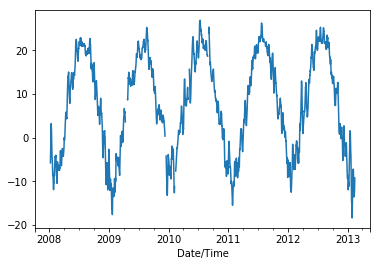

In [8]:
# weekly rolling average
mont1['Temp (°C)'].rolling(168).mean().plot();

Checking null values

In [9]:
for year in range(2008,2015):
    if str(year) in mont1['Year']:
        print ((year,'has', mont1[str(year)]['Temp (°C)'].isnull().sum(), "null values"))
    else:
        print(year, 'is not in the index')


(2008, 'has', 0, 'null values')
(2009, 'has', 3, 'null values')
(2010, 'has', 3, 'null values')
(2011, 'has', 1, 'null values')
(2012, 'has', 0, 'null values')
(2013, 'has', 7691, 'null values')
(2014, 'has', 8760, 'null values')


Erasing null values (they can be messy when concatenating dataframes)

In [10]:
mont1=mont1.dropna(axis=0,subset=['Temp (°C)'])

## load data from 2013 onwards from another station (it changed)

In [11]:
r_end=pd.date_range(start='1/1/2013',end='12/31/2015',freq='M').strftime("%m%d%Y")
r_beg=pd.date_range('1/01/2013',end='12/01/2015',freq='MS').strftime("%m%d%Y")
# loop two the two ranges of dates simultaneously to generate the desired names
names=[]
for dates_ini,dates_end in zip(r_beg,r_end):    
    #print ("eng-hourly-"+dates_ini+"-"+dates_end+".csv")
    names.append("eng-hourly-"+dates_ini+"-"+dates_end+".csv")

In [12]:
l2=[]
for files in names:
    files='temperature/51157/'+files
    l2.append(pd.read_csv(files, skiprows=16, index_col='Date/Time', parse_dates=True))
mont2=pd.concat(l2)

In [13]:
for year in range(2013,2016):
    print ((year,'has', mont2[str(year)]['Temp (°C)'].isnull().sum(), "null values"))

(2013, 'has', 1055, 'null values')
(2014, 'has', 3, 'null values')
(2015, 'has', 8, 'null values')


from march 2013 onwards the data comes from a different weather station (also located at the airport)

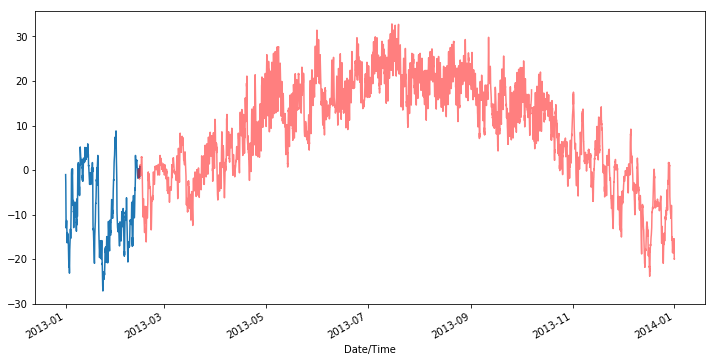

In [14]:
mont1['2013']['Temp (°C)'].plot(figsize=[12,6])
mont2['2013']['Temp (°C)'].plot(figsize=[12,6],color='r',alpha=0.5);

it's quite good, the chunk of 2013 missing in the second station is in the first one. Otherwise, very few missing values.

In [15]:
weather_mont=pd.concat([mont1,mont2])

Eliminating some duplicated elements in the index

In [16]:
len(weather_mont.loc[weather_mont.index.duplicated()])

1069

In [17]:
weather_mont=weather_mont[~weather_mont.index.duplicated(keep='first')]

In [18]:
len(weather_mont.loc[weather_mont.index.duplicated()])

0

Temperature looks good

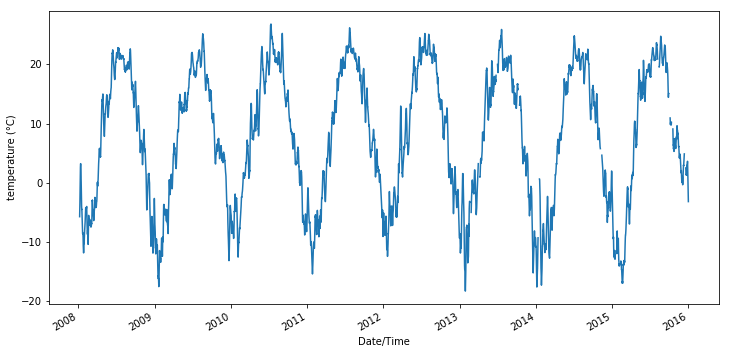

In [19]:
a=weather_mont['Temp (°C)'].rolling(168).mean().plot(figsize=[12,6])
a.set_ylabel('temperature (°C)')

In [20]:
weather_mont.to_csv('weather_montreal_2008_2015.csv')

### Calculate "heating degree hours" and "heating degree days"

In [21]:
weather_mont['HDH']=weather_mont['Temp (°C)'].apply(lambda x: 18-x if x<18 else 0)

In [22]:
weather_mont['HDD']=weather_mont['HDH'].resample('D').transform('sum')

In [23]:
weather_mont['HDD'].mean()/weather_mont['HDD'].max()

0.26400349337342272

In [24]:
weather_mont['HDH'].mean()/weather_mont['HDH'].max()

0.24964241559840591

the hourly data gives a more extreme value. makes sense, daily averaging smooths some of the temperature peaks.  if we use monthly values the availability factor increases a lot, because we underestimate the peak need.

## alternative method using the number of equivalent hours

An alternative method to calculate the availability factor consist in estimate the *number of equivalent full-load hours*, as defined by Papakostas et al 2009 (doi:10.1016/j.apenergy.2008.10.017).  

\begin{equation*}
N_{eq} = \frac{\sum_1^m N_{bin,i}\cdot (T_{bal}-T_{o,i})}{(T_{bal}-T_{ODH})}
\end{equation*}

where $N_{eq}$ are the number of equivalent full hours, $N_{bin,i}$ is the number of hours within the bin i, $T_{o,i}$ is the outside temperature in the bin i, $T_{bal}$ is the balance temperature and $T_{ODH}$ is the outdoor design temperature of the heating period.

The total of full-load equivalent hours in a period divided by the number of hours in a period gives an estimator of the availability factor.

For ilustrating purposes we can have a look to the histogram of temperature data between 2008 and 2009

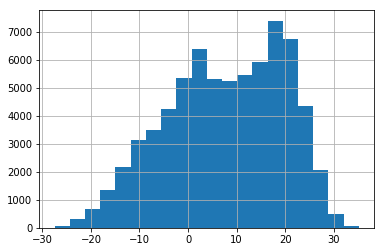

In [25]:
weather_mont['Temp (°C)'].hist(bins=20)

Create the bins

better to specify the bins so we have a "cut" at 18C, the balance temperature

In [26]:
bins2=list(range(-28,20,2))

In [27]:
temp_mont=weather_mont[['Temp (°C)']]

$T_{ODH}$ is the outdoor design temperature of the heating period, the minimum temperature registered during the observed years can be used as design temperature. for the $T_{bal}$ we will use 18 $^{\circ}$C, which is a common threshold balancepoint and consistent with empirical observations.

In [28]:
temp_mont['Temp (°C)'].min()

-27.5

In [29]:
temp_mont.loc[:,'bin']=pd.cut(temp_mont['Temp (°C)'],bins2,precision=1)

C:\Users\sinso\Anaconda3\envs\bw2\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\sinso\Anaconda3\envs\bw2\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [30]:
binned=temp_mont[['Temp (°C)','bin']].groupby('bin').agg(['mean','count'])

In [31]:
binned

Temp (°C)      
                 mean count
bin                        
(-28, -26] -26.754839    31
(-26, -24] -24.848276    58
(-24, -22] -22.855838   197
(-22, -20] -20.895862   290
(-20, -18] -18.844294   517
(-18, -16] -16.881321   787
(-16, -14] -14.905329  1126
(-14, -12] -12.908339  1463
(-12, -10] -10.935381  1823
(-10, -8]   -8.936443  2176
(-8, -6]    -6.972739  2256
(-6, -4]    -4.921041  2652
(-4, -2]    -2.979503  2698
(-2, 0]     -0.904346  3221
(0, 2]       1.045643  4441
(2, 4]       3.043448  3793
(4, 6]       5.067228  3326
(6, 8]       7.060487  3447
(8, 10]      9.066730  3183
(10, 12]    11.076110  3537
(12, 14]    13.062967  3451
(14, 16]    15.065542  3973
(16, 18]    17.047920  4374

In [32]:
Neqh=(binned['Temp (°C)','count']*(18-binned['Temp (°C)','mean'])/(18-temp_mont['Temp (°C)'].min())).sum()

The number of equivalent hours in the observed period  divided by the lenght of the period (in hours) provides an estimate of the AF:

In [33]:
Neqh/len(temp_mont)

0.24964241559840591

which is indeed very similar to our alternative estimate:

In [34]:
weather_mont['HDD'].mean()/weather_mont['HDD'].max()

0.26400349337342272